<a href="https://colab.research.google.com/github/Gio-AbouJaoude/QML-CLassifier/blob/main/QML_NN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# https://arxiv.org/pdf/2007.14044.pdf
# https://pennylane.ai/qml/demos/tutorial_backprop.html
# https://pennylane.ai/qml/demos/tutorial_variational_classifier.html
# https://towardsdatascience.com/optimizers-for-training-neural-network-59450d71caf6
# https://pennylane.readthedocs.io/en/tutorials-rotoselect/tutorials/pennylane_run_rotoselect.html
# https://conference.ippp.dur.ac.uk/event/929/attachments/3968/4559/piotr_gawron_quantum_neural_networks.pdf

In [ ]:
!pip install qiskit
!pip install pennylane
!pip install pylatexenc
!pip install pennylane-qiskit

import numpy as np
import pandas as pd
import seaborn as sns
import pennylane as qml
import plotly.express as px
import matplotlib.pyplot as plt

from qiskit import IBMQ
from qiskit import QuantumCircuit
from qiskit import QuantumRegister
from qiskit import ClassicalRegister

from sklearn.datasets import load_iris
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

     |████████████████████████████████| 6.1 MB 6.1 MB/s 
     |████████████████████████████████| 17.9 MB 94 kB/s 
     |████████████████████████████████| 235 kB 50.2 MB/s 
     |████████████████████████████████| 207 kB 47.7 MB/s 
     |████████████████████████████████| 2.1 MB 48.9 MB/s 
     |████████████████████████████████| 200 kB 58.5 MB/s 
     |████████████████████████████████| 634 kB 33.7 MB/s 
     |████████████████████████████████| 1.4 MB 47.2 MB/s 
     |████████████████████████████████| 52 kB 1.4 MB/s 
     |████████████████████████████████| 943 kB 38.1 MB/s 
     |████████████████████████████████| 38.2 MB 25 kB/s 
     |████████████████████████████████| 49 kB 5.9 MB/s 
     |████████████████████████████████| 3.0 MB 57.0 MB/s 
     |████████████████████████████████| 6.3 MB 48.4 MB/s 
  Created wheel for qiskit: filename=qiskit-0.30.0-py3-none-any.whl size=11273 sha256=2093c4df1a2527a01ec287018c9632af8e7cb2d820d7c604956b43b7a7df885f
  Stored in directory: /root/.cache/pip/whee

In [ ]:
#IBMQ.save_account('Insert Token Here')

In [ ]:
# qml is the Penny Lane Library
dev = qml.device("default.qubit", wires= 2)

#dev = qml.device('qiskit.ibmq', wires=2, backend='ibmq_santiago', shots=5)
#dev = qml.device('qiskit.ibmq', wires=2, backend='ibmq_qasm_simulator', shots=3)

#dev.capabilities()['backend']

nParams = 7
@qml.qnode(dev, diff_method="parameter-shift")
def circuit(features, params):
  
  qml.RX(features[0], wires=0)
  qml.RX(features[1], wires=1)

  qml.broadcast(qml.CZ, wires=[0, 1], pattern="ring")

  qml.RX(params[0], wires=0)
  qml.RX(params[1], wires=1)

  qml.broadcast(qml.CZ, wires=[1, 0], pattern="ring")

  qml.RX(features[2], wires=0)
  qml.RX(features[3], wires=1)

  qml.broadcast(qml.CZ, wires=[0, 1], pattern="ring")

  qml.RX(params[2], wires=0)
  qml.RX(params[3], wires=1)

  qml.broadcast(qml.CZ, wires=[1, 0], pattern="ring")

  qml.RX(features[0], wires=0)
  qml.RX(features[1], wires=1)

  qml.broadcast(qml.CZ, wires=[0, 1], pattern="ring")

  qml.RX(params[4], wires=0)
  qml.RX(params[5], wires=1)

  qml.broadcast(qml.CZ, wires=[1, 0], pattern="ring")

  qml.RX(features[2], wires=0)
  qml.RX(features[3], wires=1)

  qml.broadcast(qml.CZ, wires=[0, 1], pattern="ring")

  qml.RX(params[6], wires=0)
  #qml.RX(params[7], wires=1)

  qml.broadcast(qml.CZ, wires=[1, 0], pattern="ring")

  return qml.expval(qml.PauliZ(0))

In [ ]:
# Calculates the gradient of a single parameter 
def parameter_shift_term(features, params, i):
    shifted = params.copy()
    shifted[i] += np.pi/2                 # shift parameter i forward by pi/2
    forward = circuit(features, shifted)  # forward evaluation

    shifted[i] -= np.pi                   # shift parameter i backward by pi/2, (pi/2 - pi = -pi/2)
    backward = circuit(features, shifted) # backward evaluation

    return 0.5* (forward - backward) # the difference between the forward shift and backward shift is twice the gradient

In [ ]:
# Calculates the gradients for all parameters in a given circuit
def parameter_shift(features, params):
    gradients = np.zeros([len(params)]) # initialize array of zeros

    for i in range(len(params)):
        gradients[i] = parameter_shift_term(features, params, i) # calculate the gradient for each parameter in the circuit

    return gradients # return the gradients of all parameters in a vector

In [ ]:
# Adjusts all parameters in a given circuit using the gradient to 'optimize' or 'de-optimize'
def stepFunction(features, params, optimize= True, alpha= 0.1):
  # Each dependent variable will have possible targets that span that variable (possible values of the variable)
  # Each circuit can be 'optimized' to a specific target or 'de-optimized' to a specific target

  # Each parameter is 'optimized' by moving in the positive direction (positive gradient) or 'de-optimized' by...
  # moving in the negative direction (negative gradient)

  if optimize:
    params += alpha*parameter_shift(features, params)
  else:
    params += (-alpha*0.33)*parameter_shift(features, params) #-alpha/3

  return params

In [ ]:
# Helper/utility Function for printing circuit values
def printCirc(features, params):
  print("Expectation value:", circuit(features, params))
  print("\n")
  print("Features: ", features)
  print("Parameters: ", params)
  print("\n")
  print(circuit.draw())

In [ ]:
def getQiskitCirc(features, params):
  N=2
  q=QuantumRegister(N)
  c=ClassicalRegister(N)
  qc=QuantumCircuit(q,c)

  qc.rx(features[0], 0)
  qc.rx(features[1], 1)

  qc.cz(0, 1)

  qc.rx(params[0], 0)
  qc.rx(params[1], 1)

  qc.cz(0, 1)

  qc.rx(features[2], 0)
  qc.rx(features[3], 1)

  qc.cz(0, 1)

  qc.rx(params[2], 0)
  qc.rx(params[3], 1)

  qc.cz(0, 1)

  qc.rx(features[0], 0)
  qc.rx(features[1], 1)

  qc.cz(0, 1)

  qc.rx(params[4], 0)
  qc.rx(params[5], 1)

  qc.cz(0, 1)

  qc.rx(features[2], 0)
  qc.rx(features[3], 1)

  qc.cz(0, 1)

  qc.rx(params[6], 0)

  qc.measure(0, 0)

  return qc

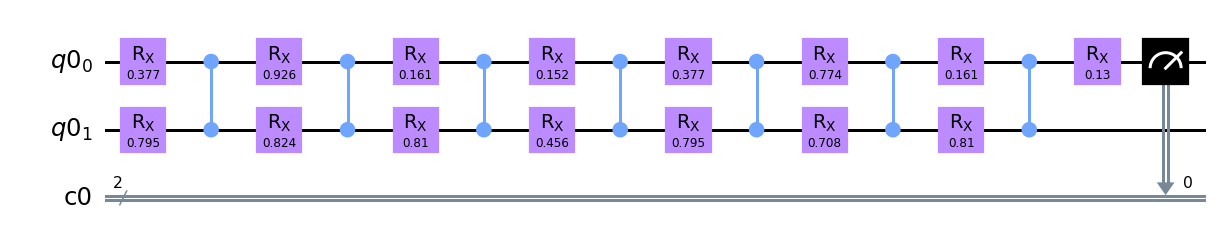

In [ ]:
# Random features and  parameters for conveying stepFunction
features = np.random.random([4])
params = np.random.random([nParams])

# Graph Qiskit circuit for visual-aid
getQiskitCirc(features, params).draw(output='mpl', scale=1.5)

In [ ]:
# Print using variables as gate inputs
print("\n")
print("0: ──RX(Feat_0)──╭C──RX(Param_0)──╭Z──RX(Feat_2)──╭C──RX(Param_2)──╭Z──RX(Feat_0)──╭C──RX(Param_4)──╭Z──RX(Feat_2)──╭C──RX(Param_6)──╭Z──┤ ⟨Z⟩")
print("                 |                |               |                |               |                |               |                |       ")
print("1: ──RX(Feat_1)──╰Z──RX(Param_1)──╰C──RX(Feat_3)──╰Z──RX(Param_3)──╰C──RX(Feat_1)──╰Z──RX(Param_5)──╰C──RX(Feat_3)──╰Z───────────────╰C──┤   ")
print("\n")



0: ──RX(Feat_0)──╭C──RX(Param_0)──╭Z──RX(Feat_2)──╭C──RX(Param_2)──╭Z──RX(Feat_0)──╭C──RX(Param_4)──╭Z──RX(Feat_2)──╭C──RX(Param_6)──╭Z──┤ ⟨Z⟩
                 |                |               |                |               |                |               |                |       
1: ──RX(Feat_1)──╰Z──RX(Param_1)──╰C──RX(Feat_3)──╰Z──RX(Param_3)──╰C──RX(Feat_1)──╰Z──RX(Param_5)──╰C──RX(Feat_3)──╰Z───────────────╰C──┤   




In [ ]:
# Print values after step function
print("These are the values of the circuit before the step function:")
#getQiskitCirc(features, params).draw(output='mpl', scale=1.5)
printCirc(features, params)
params = stepFunction(features, params)

print("\n")
print("These are the values of the circuit after the step function:")
printCirc(features, params)
#getQiskitCirc(features, params).draw(output='mpl', scale=1.5)

These are the values of the circuit before the step function:
Expectation value: 0.9022424657896534


Features:  [0.37709683 0.79547802 0.16063496 0.81000543]
Parameters:  [0.92603739 0.82387005 0.15170231 0.45579565 0.77433409 0.70838438
 0.12952253]


 0: ──RX(0.377)──╭C──RX(0.926)──╭Z──RX(0.161)──╭C──RX(0.152)──╭Z──RX(0.377)──╭C──RX(0.774)──╭Z──RX(0.161)──╭C──RX(0.13)──╭Z──┤ ⟨Z⟩ 
 1: ──RX(0.795)──╰Z──RX(0.824)──╰C──RX(0.81)───╰Z──RX(0.456)──╰C──RX(0.795)──╰Z──RX(0.708)──╰C──RX(0.81)───╰Z────────────╰C──┤     



These are the values of the circuit after the step function:
Expectation value: 0.9212438555972301


Features:  [0.37709683 0.79547802 0.16063496 0.81000543]
Parameters:  [0.9016161  0.82762898 0.13298965 0.45535993 0.77629016 0.70487215
 0.16195916]


 0: ──RX(0.377)──╭C──RX(0.902)──╭Z──RX(0.161)──╭C──RX(0.133)──╭Z──RX(0.377)──╭C──RX(0.776)──╭Z──RX(0.161)──╭C──RX(0.162)──╭Z──┤ ⟨Z⟩ 
 1: ──RX(0.795)──╰Z──RX(0.828)──╰C──RX(0.81)───╰Z──RX(0.455)──╰C──RX(0.795)──╰Z──RX(0.705)──╰

In [ ]:
# Helper/utility function for initializing weights at random, can be seeded
def getWeights(nCircuits, nParams, rngSeed):
  weights = [] # Initialize weights

  np.random.seed(seed= rngSeed) # Seed random number generator for study of anomolies
  for i in range(nCircuits):
    params = np.random.random([nParams]) # Generate and append random weights
    weights.append(params)

  return weights # Return random weights

In [ ]:
iris = load_iris() # loads the iris data set from sklearn

X = iris.data   # loads independent variables from dataset
Y = iris.target # loads dependent variables from dataset

#X = MinMaxScaler().fit(X).transform(X) # Normalizes features of the Iris data set
X = StandardScaler().fit(X).transform(X) # Standardizes features of the Iris data set               <----- See the difference between normalize and standardize
# Y values are categorical and do not need standerdizing

sSeed = 42 # RNG seed for the train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.25, random_state= sSeed)
# Split the data into a set of training and testing sets

In [ ]:
# Predicts the classification of a dependent variable by using a circuit for each target, this is the classifier
def predClassification(features, weights, nCircuits = 3):
  expectations = [0]*nCircuits # Initialize zeros for classifier

  for j in range(len(expectations)):
    expectations[j] = circuit(features, weights[j])      # Get the expectation value from each circuit, one for each target

  classification = expectations.index(max(expectations)) # Get the index of the largest expectation value, which is taken as the predicted value
  return classification # Return predicted value

In [ ]:
# Predict all classifications of a given array of features
def predAll(weights, X_test, nCircuits = 3):
  Y_estimate = [0]*len(X_test)

  for i in range(len(X_test)):
    Y_estimate[i] = predClassification(X_test[i], weights, nCircuits) # Predict the classification for every row of features

  return Y_estimate # Return classifications

In [ ]:
# Detect and 'optimize'/'de-optimize' the appropriate circuits, optimizing the entire classifier
def optimizeClassifier(features, target, weights, nCircuits):
 
  notTargets = [j for j in range(nCircuits) if j != target]

  weights[target] = stepFunction(features, weights[target])

  for j in notTargets:
    weights[j] = stepFunction(features, weights[j], optimize = False)
  
  return weights

In [ ]:
# Generate standard classification metrics in a dictionary
def metricsTest(weights, X_test, Y_test, nCircuits = 3, method= 'weighted'):

  Y_estimate = predAll(weights, X_test, nCircuits) # Estimate dependent variable for every row in the test set

  # The estimated variable and the actual variable are used to calculate/generate metrics for the classifier

  metrics = {}
  metrics['confMatrix'] = confusion_matrix(Y_test, Y_estimate)                                            # Generate confusion matrix
  metrics['precision'] = precision_score(Y_test, Y_estimate, average=method, labels=np.unique(Y_estimate))# Generate percision score
  metrics['accuracy'] = accuracy_score(Y_test, Y_estimate)                                                # Generate accuracy score
  metrics['recall'] = recall_score(Y_test, Y_estimate, average=method)                                    # Generate recall score
  metrics['f1Score'] = f1_score(Y_test, Y_estimate, average=method)                                       # Generate F1 score
  
  return metrics # Return dictionary of metrics


# Helper/utility function for printing metrics dictionary
def printMetricTest(epoch, metrics):

  def percent(value):
    return str(round(value*100, 2))+'%'

  print("         At epoch number: "+str(epoch)+"       ")

  print("-------------------------------------")

  print("Precision: ", percent(metrics['precision']))
  print("Accuracy: ", percent(metrics['accuracy']))
  print("Recall: ", percent(metrics['recall']))
  print("F1: ", percent(metrics['f1Score']))

  print("Confusion Matrix: ")
  cmtx = pd.DataFrame(metrics['confMatrix'], 
    index=['true: 0', 'true: 1', 'true: 2'], 
    columns=['pred: 0', 'pred: 1', 'pred: 2'])
  print(cmtx)

  print("*************************************")

In [ ]:
# The three functions below are for storing values in large arrays, will later be recoded to save in a file (json or simple array txt)

# Record the weights of the classifier in an array
def getWeightRecord(weights):
  allWeights = np.reshape(weights, len(weights)*len(weights[0]))
  return allWeights

# Record the metrics of the classifier in an array
def getMetricsRecord(metrics):
  return [metrics['accuracy'], metrics['precision'], metrics['recall'], metrics['f1Score']]

# Helper/utility function for stacking array
def stackData(allData, newRow):
  return np.vstack([allData, newRow])

In [ ]:
# Train the classifier by selecting which circuit to 'optimize' and which circuits to 'de-optimize' also records all weights and metrics in arrays
def trainIrisClassifier(weights, nCircuits, X_train, Y_train, X_test, Y_test, nEpochs = 5, display = False):

  # Get the metrics evaluation for the classifier with random weights, before any training
  metrics = metricsTest(weights, X_test, Y_test, nCircuits)

  printMetricTest(0, metrics) if display else None # Printing is optional

  # Record the weights and metrics for the class in array form, this and every other recording can be recoded to write to an external file
  weightData = getWeightRecord(weights)
  metricData = getMetricsRecord(metrics)
  
  # Train for several epochs, each epoch is going through the training data set once
  for n in range(nEpochs):

    # Iterate through the training data set
    for i in range(len(X_train)):

      # Optimize the classifier
      weights = optimizeClassifier(X_train[i], Y_train[i], weights, nCircuits)

      # Record the weights and metrics after each optimization of the classifier for in-depth study
      metrics = metricsTest(weights, X_test, Y_test, nCircuits)
      weightData = stackData(weightData, getWeightRecord(weights))
      metricData = stackData(metricData, getMetricsRecord(metrics))

    printMetricTest(n+1, metrics) if display else None # Printing is optional

  # Convert the records of the weights and metrics to dataframe form for easier study, can be easily commented out
  wDf = pd.DataFrame(weightData)
  mDf = pd.DataFrame(metricData, columns=['accuracy', 'percision', 'recall', 'f1Score'])

  return weights, wDf, mDf # Returns the final 'trained' weights, weight dataframe and metrics dataframe

In [ ]:
nEpochs = 13
wSeed = 42 # Seed np random number generator
nCircuits= 3 # The number of targets/number of circuits
weights = getWeights(nCircuits, nParams, wSeed)

# Train a data set for use in analysis, set display= False to avoid printing
weights, wDf, mDf = trainIrisClassifier(weights, nCircuits, X_train, Y_train, X_test, Y_test, nEpochs = nEpochs, display= True)

         At epoch number: 0       
-------------------------------------
Precision:  11.83%
Accuracy:  15.79%
Recall:  15.79%
F1:  12.48%
Confusion Matrix: 
         pred: 0  pred: 1  pred: 2
true: 0        1        7        7
true: 1        4        5        2
true: 2        3        9        0
*************************************
         At epoch number: 1       
-------------------------------------
Precision:  59.13%
Accuracy:  55.26%
Recall:  55.26%
F1:  54.96%
Confusion Matrix: 
         pred: 0  pred: 1  pred: 2
true: 0        7        1        7
true: 1        1        9        1
true: 2        1        6        5
*************************************
         At epoch number: 2       
-------------------------------------
Precision:  85.31%
Accuracy:  84.21%
Recall:  84.21%
F1:  84.44%
Confusion Matrix: 
         pred: 0  pred: 1  pred: 2
true: 0       12        0        3
true: 1        0       10        1
true: 2        1        1       10
*********************************

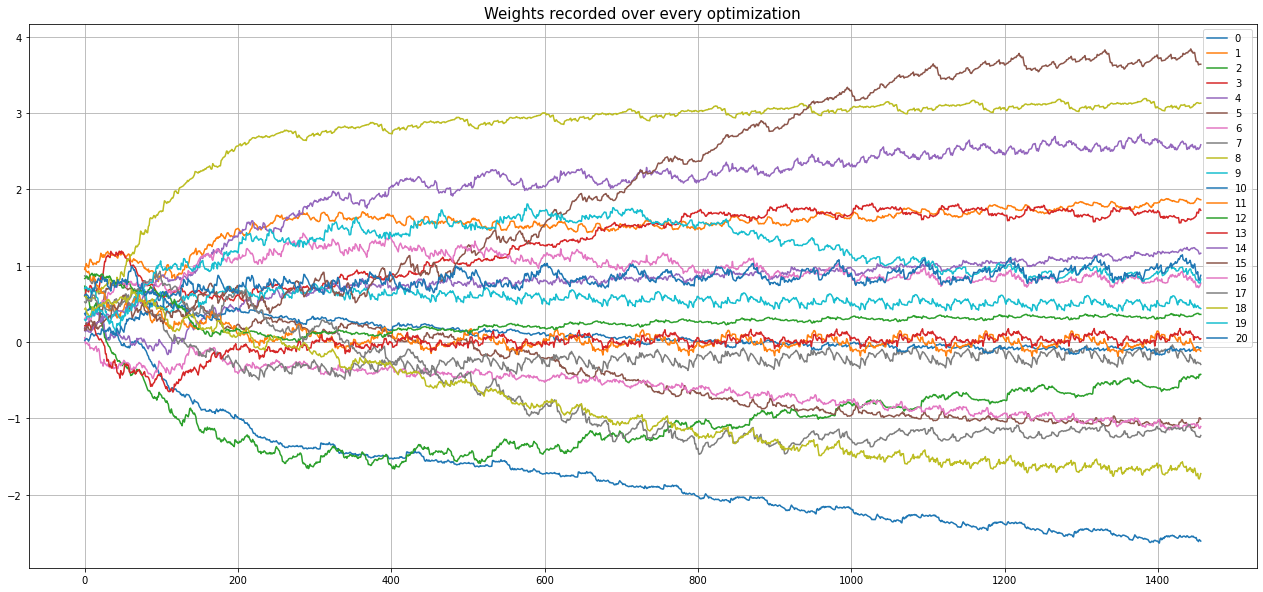

In [ ]:
# Print weights, weights are unitless
wDf.plot(figsize=(22,10), title= 'Weights recorded over every optimization', grid=True).title.set_size(15)

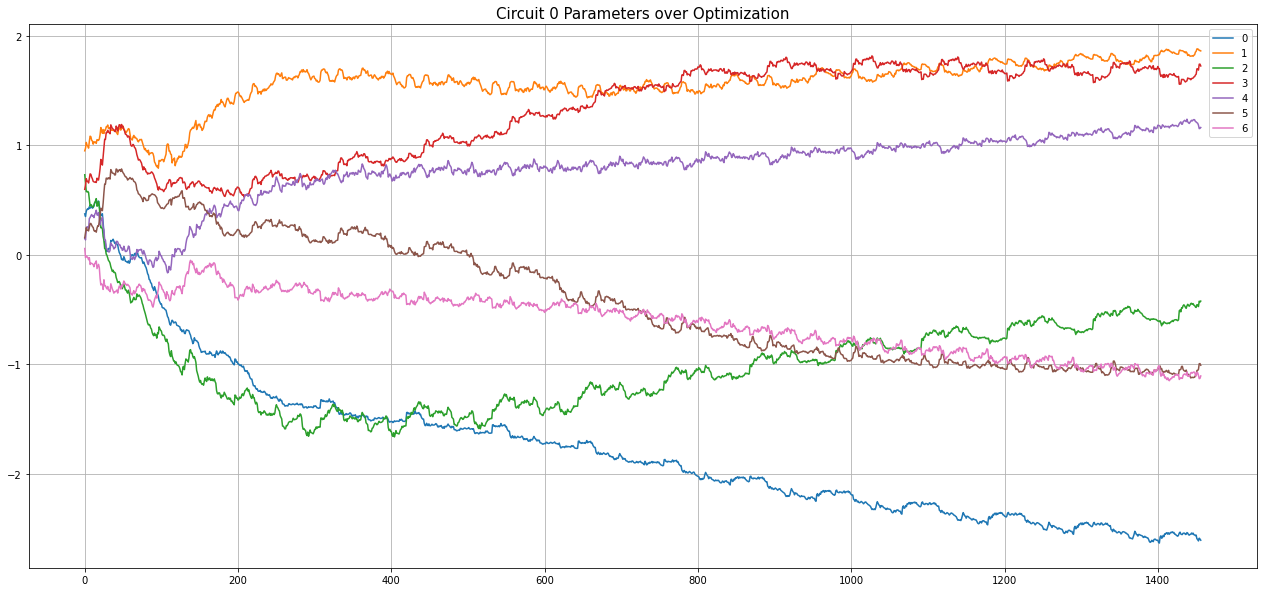

In [ ]:
circ_0 = wDf.iloc[:, 0:nParams]
circ_0.plot(figsize=(22,10), title= "Circuit 0 Parameters over Optimization", grid=True).title.set_size(15)

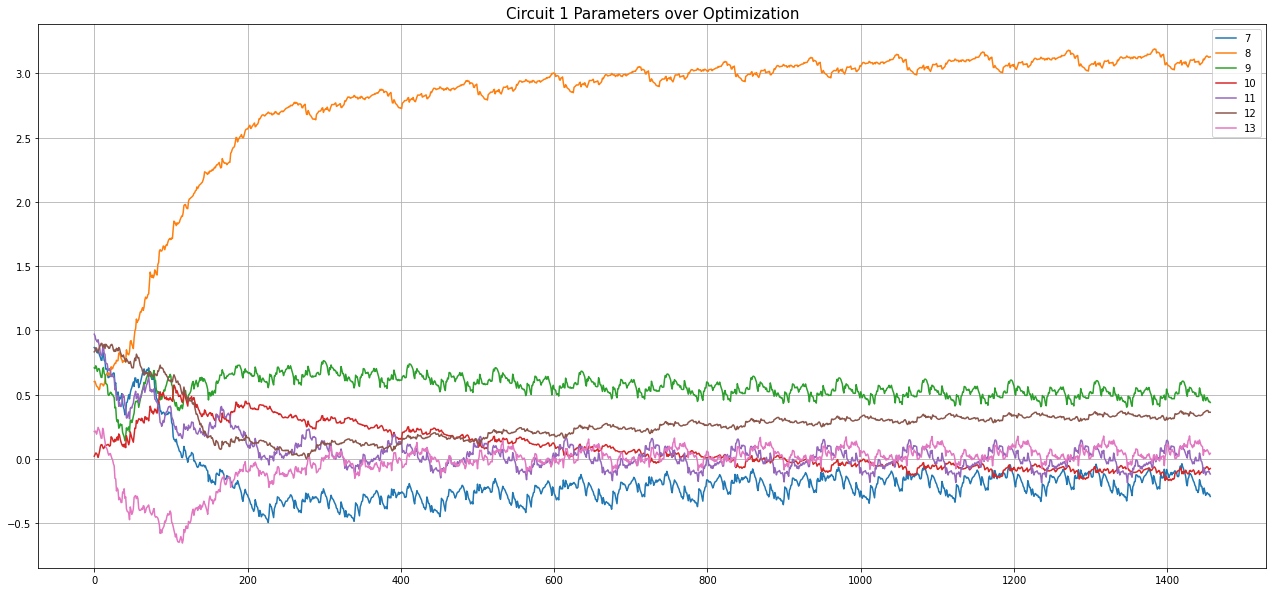

In [ ]:
circ_1 = wDf.iloc[:, (nParams):(2*nParams)]
circ_1.plot(figsize=(22,10), title= "Circuit 1 Parameters over Optimization", grid=True).title.set_size(15)

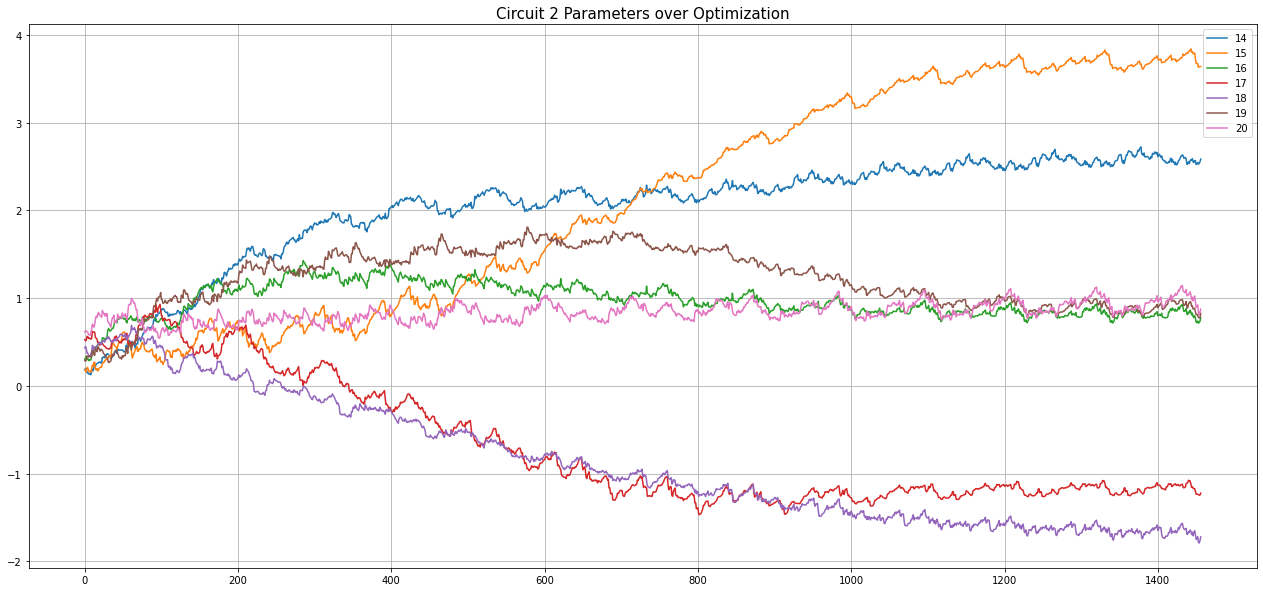

In [ ]:
circ_2 = wDf.iloc[:, (2*nParams):(3*nParams)]
circ_2.plot(figsize=(22,10), title= "Circuit 2 Parameters over Optimization", grid=True).title.set_size(15)

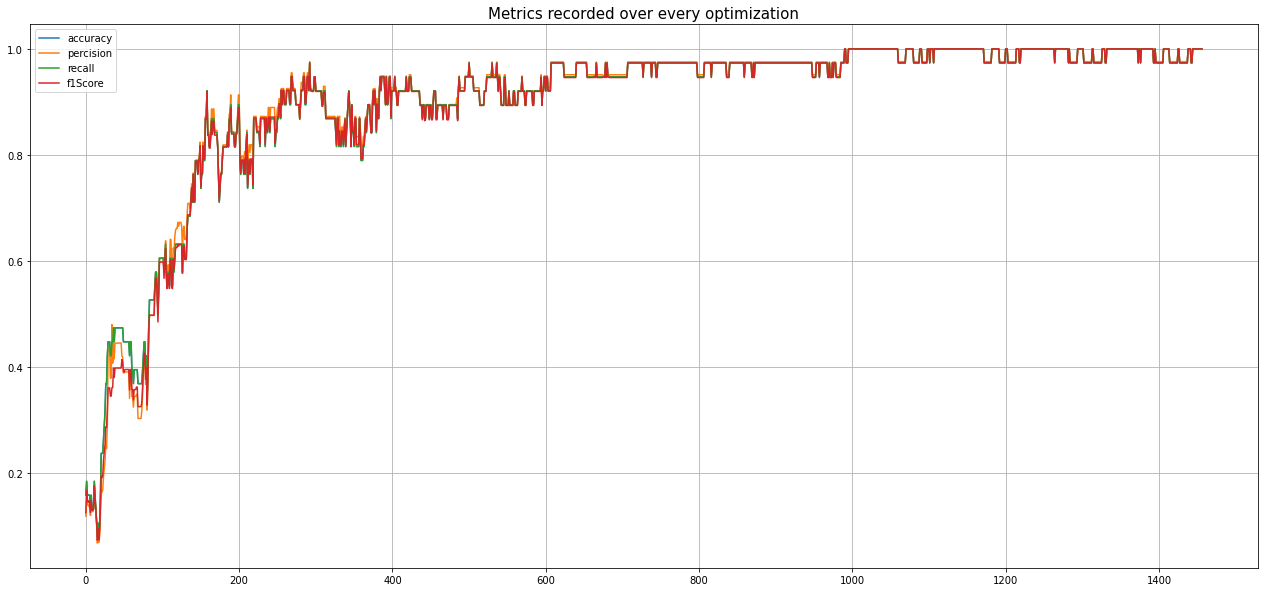

In [ ]:
# Print metrics, metrics are unitless
mDf.plot(figsize=(22,10), title= 'Metrics recorded over every optimization', grid=True).title.set_size(15)

In [ ]:
# The four functions below are for calculating basic statistical information in colums of data or dataframes

# Calculate statistics for a one dimensional array of data
def getStats(col):
  stats = {}
  stats['minimum'] = min(col)
  stats['maximum'] = max(col)
  stats['mean'] = sum(col) / len(col)
  stats['var'] = sum((i - stats['mean']) ** 2 for i in col) / len(col)
  return stats # Returns a dictionary

# Calculate statistics for every column in a dataframe
def getAllStats(df):
  allStats = {}
  for col in df:
    allStats[col+'Stats'] = getStats(df[col])
  return allStats # Returns a dictionary of dictionaries

# Prints the statistics from a one dimensional array stored in a dictionary
def printStats(stats):
  print("minimum value: ", stats['minimum'])
  print("maximum value: ", stats['maximum'])
  print("average value: ", stats['mean'])
  print("variance value: ", stats['var'])

# Print the statistics from a dataframe stored in a dictionary of dictionaries
def printAllStats(dictionary):
  for key in dictionary:
    print("Column ", "-"+key+"-", " information")
    printStats(dictionary[key])
    print("**********************************************")

In [ ]:
# Create 'synthetic' features to outline the classifier's decision making process
def prodSynthData(X, weights, names, nPoints = 10, buffer = 0.1):
  
  _, nFeatures = X.shape
  synthFeatures = [0]*nFeatures

  # 10^n data points are produced, where n is the number of features
  synthData = np.zeros((nPoints**nFeatures, nFeatures+1), float)

  # Each column of synthetic features will range from slightly smaller than the smallest value in that column and vice versa for the largest
  for n in range(nFeatures):
    feat_min, feat_max = X[:, n].min() - buffer, X[:, n].max() + buffer
    synthFeatures[n] = np.linspace(feat_min, feat_max, num= nPoints)

  i = 0
  for val_0 in synthFeatures[0]:
    for val_1 in synthFeatures[1]:
      for val_2 in synthFeatures[2]:
        for val_3 in synthFeatures[3]:  
          # Iterate through every possible combination of the features and classify them
          classification = predClassification([val_0, val_1, val_2, val_3], weights)
          synthData[i] = [val_0, val_1, val_2, val_3, classification]
          i= i+1

  return pd.DataFrame(synthData, columns= names) # Return the 'synthetic' features and classifications as a dataframe

# Helper/utility function to get statistics on the 'synthetic' classifications made in the previous function
def getTargetStats(df, targetName, target):
  df = df[df[targetName] == target]
  df = df.drop([targetName], axis=1)
  allStats = getAllStats(df)
  return allStats

In [ ]:
# Produce 'synthetic' features and classifications
synthNames = ['SepalL', 'SepalW', 'PetalL', 'PetalW', 'SynthPrediction']
synthFlowers = prodSynthData(X, weights, synthNames, nPoints= 15)

# Rename imported/'real' features and known/'actual' classifications as a dataframe
realFlowers = pd.DataFrame(X, columns=['SepalL', 'SepalW', 'PetalL', 'PetalW'])
realFlowers['ActualFlower'] = Y

In [ ]:
# Print the first few and last few rows for inspection
print(synthFlowers)

         SepalL    SepalW    PetalL    PetalW  SynthPrediction
0     -1.970024 -2.533947 -1.667576 -1.547076              0.0
1     -1.970024 -2.533947 -1.667576 -1.307136              0.0
2     -1.970024 -2.533947 -1.667576 -1.067195              0.0
3     -1.970024 -2.533947 -1.667576 -0.827254              0.0
4     -1.970024 -2.533947 -1.667576 -0.587313              0.0
...         ...       ...       ...       ...              ...
50620  2.592019  3.190775  1.885832  0.852332              2.0
50621  2.592019  3.190775  1.885832  1.092273              2.0
50622  2.592019  3.190775  1.885832  1.332214              2.0
50623  2.592019  3.190775  1.885832  1.572155              2.0
50624  2.592019  3.190775  1.885832  1.812096              2.0

[50625 rows x 5 columns]


In [ ]:
# Graph the correlation matrix of a dataframe using one-hot encoding for categorical target
def graphCorrelations(df, targetName, fName = 'Correlation Matrix'):
  hot = pd.get_dummies(df[targetName])# , prefix='flower '
  df = pd.concat([df, hot], axis=1)
  df = df.drop([targetName], axis=1)

  corr = df.corr()

  mask = np.zeros_like(corr, dtype=np.bool)
  mask[np.triu_indices_from(mask)] = True

  plt.subplots(figsize=(12, 11))

  sns.heatmap(round(corr, 2), mask= mask, 
              cmap= sns.diverging_palette(220, 10, as_cmap=True), 
              annot=True, vmax=1, vmin=-1, center=0, square=True, 
              linewidths=.8, cbar_kws={"shrink": .8})
  
  plt.title(fName, fontsize=15)


# Graph a heat map from the perspective of the features, 3 dimensional histogram with counts in the z axis but represented by contours
def heatMap(realXFeature, realYActual, synthXFeature, synthYPrediction):
  fig, ax = plt.subplots(figsize=(11, 9))
  sns.kdeplot(ax=ax, x= synthXFeature, y= synthYPrediction, cmap= "Reds", shade=False, thresh=False)
  sns.kdeplot(ax=ax, x= realXFeature, y= realYActual, cmap= "YlOrBr", shade=False, thresh=False)
  plt.title("QML 2D KDE Elevation & Relief Map: Real Flowers-Yellow & Synthetic Flowers-Red", fontsize=15)
  plt.ylabel('Flower Classification')
  

# Graph a two dimensional histogram from the perspective of the target
def targetPlot(df, targetName, target, colorArr):
  df = df[df[targetName] == target]
  df = df.drop([targetName], axis=1)
  fig, ax = plt.subplots(figsize=(10, 9))
  for i, col in enumerate(df):
    sns.kdeplot(ax=ax, data=df[col], color=colorArr[i], shade=False, Label=col)
    #https://seaborn.pydata.org/generated/seaborn.kdeplot.html
  plt.title('Kernel Density Estimate: Iris '+str(target)).set_size(15)
  plt.legend()
  plt.xlabel('Feature Values')
  plt.ylabel('Density Estimate')
  plt.show()

def pairPlot(df, targetName, fName):
  sns.set()
  graph = sns.pairplot(data= df, hue= targetName, diag_kind="kde", diag_kws=dict(fill=False), markers=["o", "s", "D"])
  graph.fig.suptitle(fName, y= 1.01, fontsize= 18)

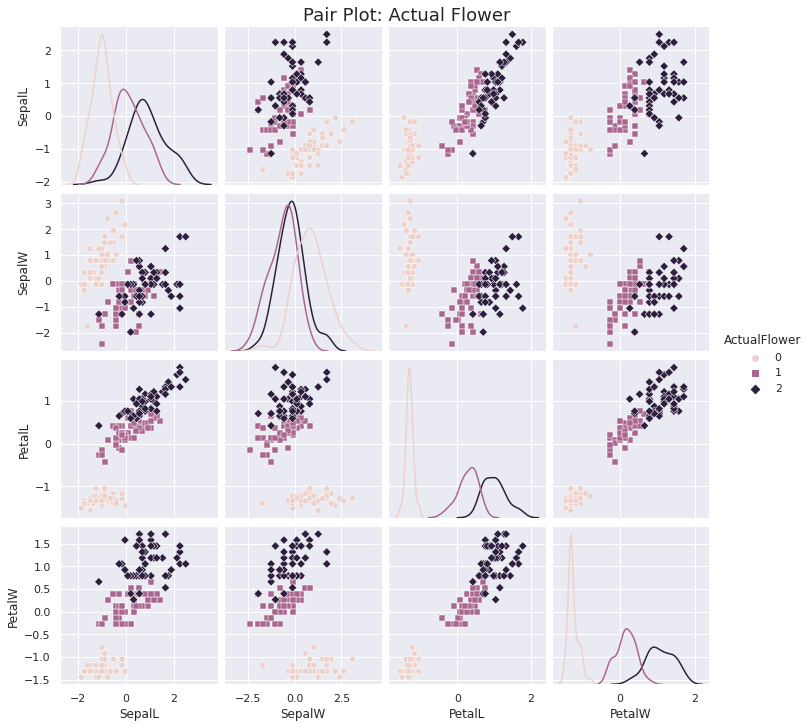

In [ ]:
pairPlot(realFlowers, 'ActualFlower', 'Pair Plot: Actual Flower')

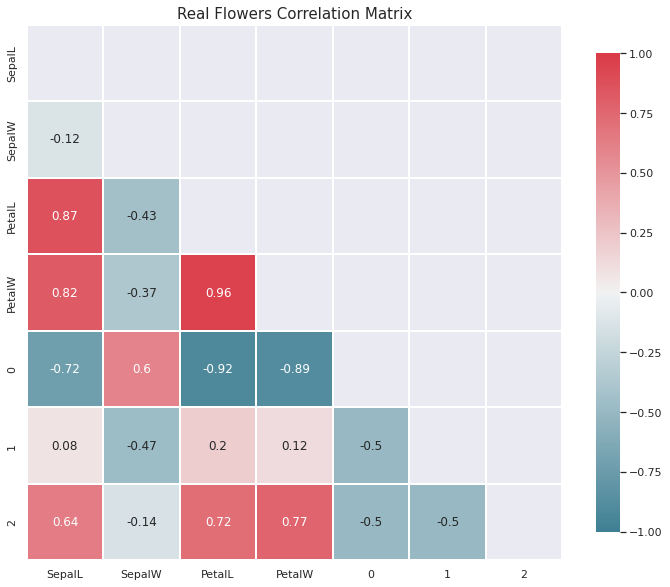

In [ ]:
graphCorrelations(realFlowers, 'ActualFlower', fName ='Real Flowers Correlation Matrix')

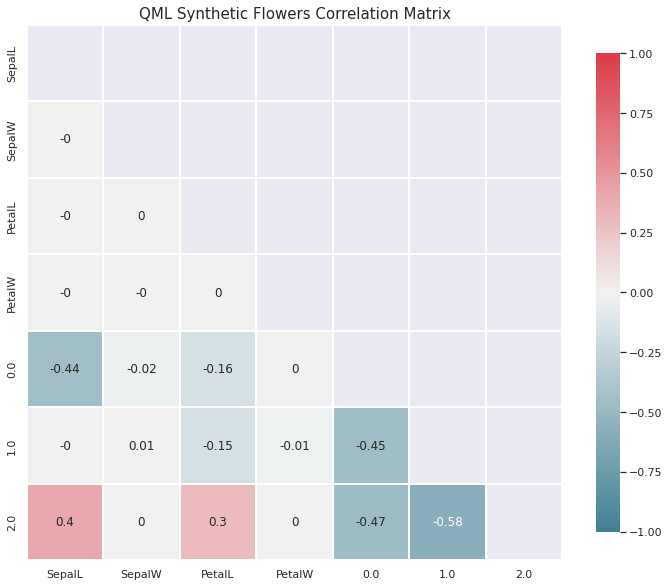

In [ ]:
graphCorrelations(synthFlowers, 'SynthPrediction', fName ='QML Synthetic Flowers Correlation Matrix')

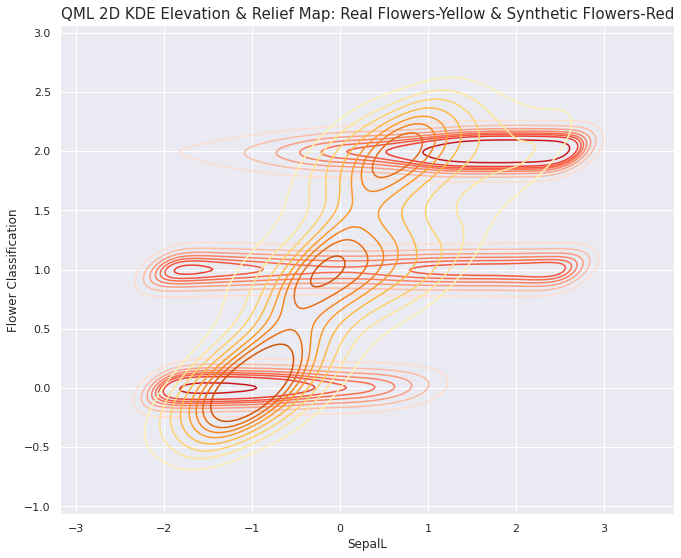

In [ ]:
heatMap(realFlowers['SepalL'], realFlowers['ActualFlower'], synthFlowers['SepalL'], synthFlowers['SynthPrediction'])

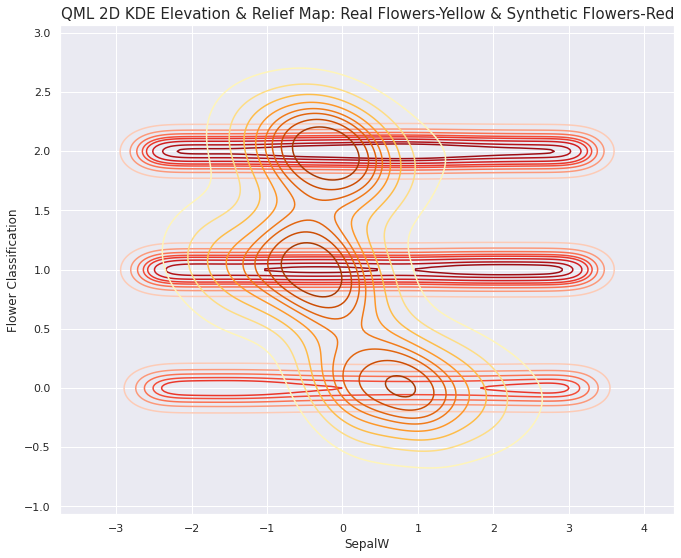

In [ ]:
heatMap(realFlowers['SepalW'], realFlowers['ActualFlower'], synthFlowers['SepalW'], synthFlowers['SynthPrediction'])

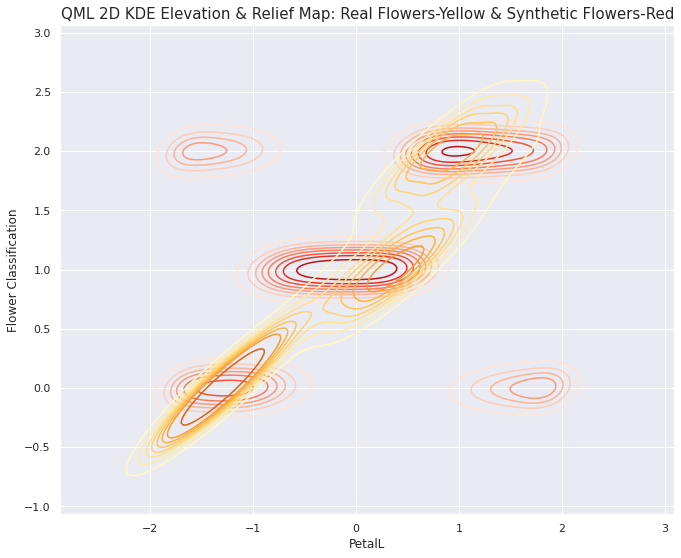

In [ ]:
heatMap(realFlowers['PetalL'], realFlowers['ActualFlower'], synthFlowers['PetalL'], synthFlowers['SynthPrediction'])

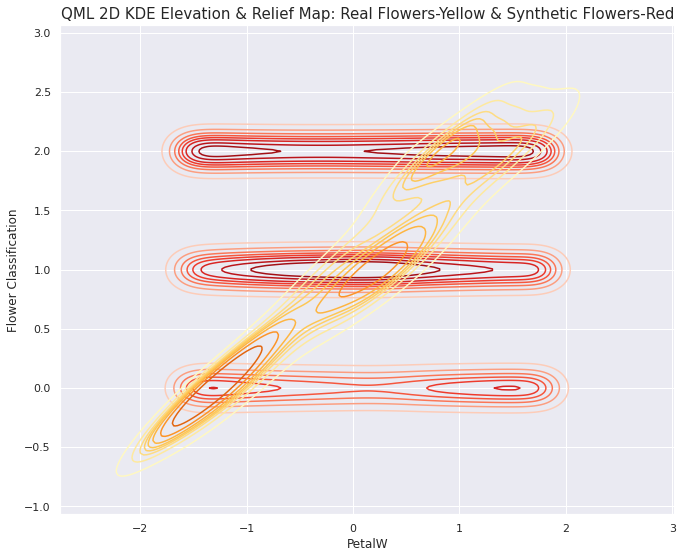

In [ ]:
heatMap(realFlowers['PetalW'], realFlowers['ActualFlower'], synthFlowers['PetalW'], synthFlowers['SynthPrediction'])

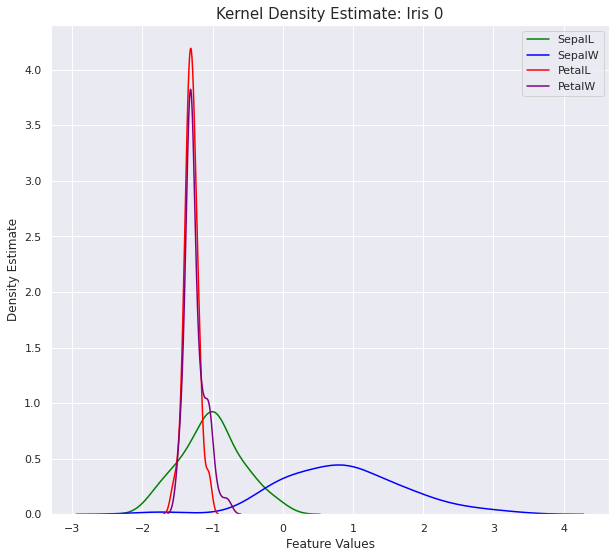

In [ ]:
targetPlot(realFlowers, 'ActualFlower', 0, colorArr = ['green', 'blue', 'red', 'purple'])

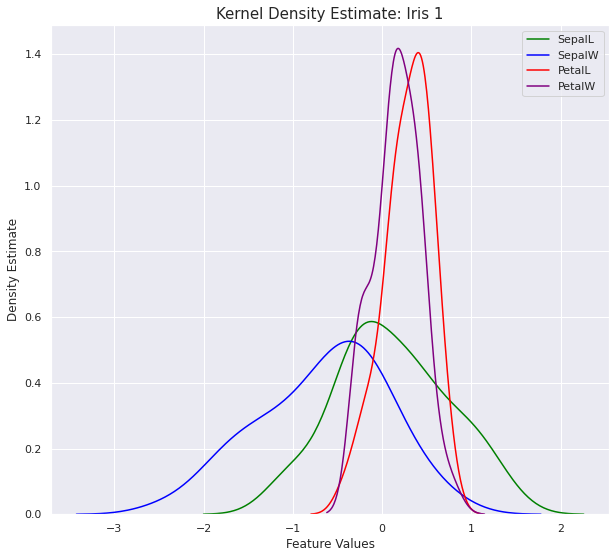

In [ ]:
targetPlot(realFlowers, 'ActualFlower', 1, colorArr = ['green', 'blue', 'red', 'purple'])

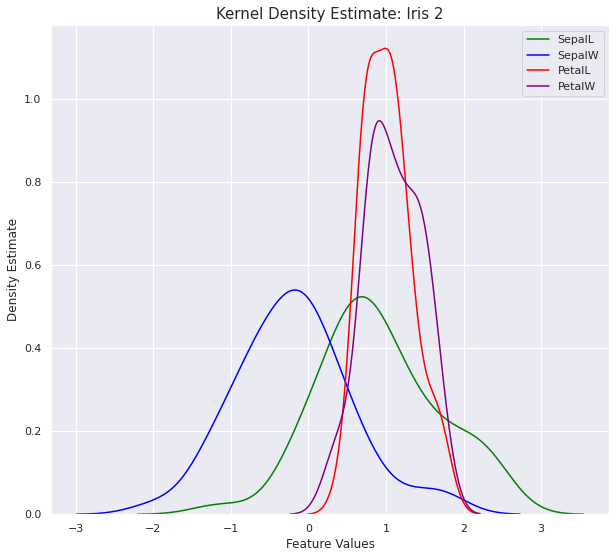

In [ ]:
targetPlot(realFlowers, 'ActualFlower', 2, colorArr = ['green', 'blue', 'red', 'purple'])

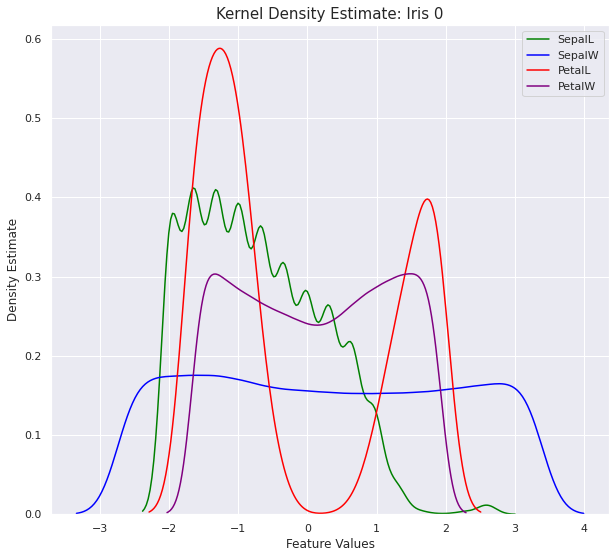

In [ ]:
targetPlot(synthFlowers, 'SynthPrediction', 0, colorArr = ['green', 'blue', 'red', 'purple'])

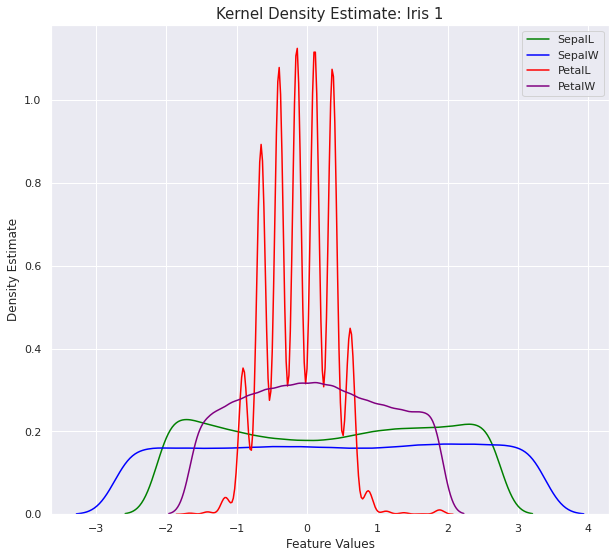

In [ ]:
targetPlot(synthFlowers, 'SynthPrediction', 1, colorArr = ['green', 'blue', 'red', 'purple'])

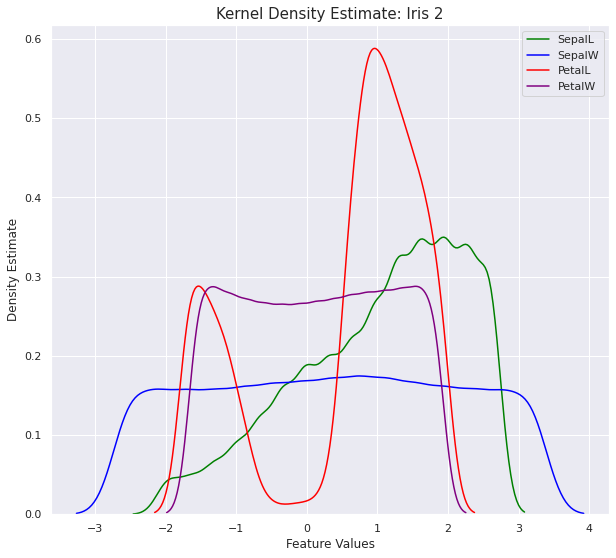

In [ ]:
targetPlot(synthFlowers, 'SynthPrediction', 2, colorArr = ['green', 'blue', 'red', 'purple'])